In [1]:
%%capture
pip install prometheus-api-client

In [2]:
%%capture
pip install matplotlib

In [3]:
%%capture
pip install stumpy

In [4]:
from prometheus_api_client import *
import matplotlib.pyplot as plt
import os
import numpy as np
import sys
import datetime
import pandas
import random
import seaborn as sns
# Set default Seaborn style
sns.set(style="darkgrid")
sns.set_context("talk", font_scale=1.4)
## hides ipython warnings
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (30, 10)
#plt.rcParams['figure.figsize'] = (20, 5)

## Global Settings

In [5]:
date_rng = pandas.date_range(start='1/1/2018', end='1/08/2018', freq='T')
#date_rng.size
df = pandas.DataFrame(date_rng, columns=['date'])
print("Number of samples: ", len(df.index))

_disturb_count=10
_control = random.sample(range(0,len(df.index)),_disturb_count)
_control.sort()
print("Control points where disturbance will be added: ", _control)

_outage_width=100
_signal_lag=10

Number of samples:  10081
Control points where disturbance will be added:  [242, 1902, 2669, 3162, 4451, 4690, 6252, 8922, 9476, 10035]


## Generating Variable-0

In [6]:


def generate_policy_1(control, outage_width):
 
    control_stop = [x + outage_width for x in control]
    print("Control points where disturbance will be stopped: ", control_stop)


    result=[]
    disturb=0
    i = 0
    while (i < len(df.index)): 
         #if the current index is the point where disturbance will be added   
         exist = control.count(i)
         if exist == 1:
             result.append(1)
             disturb=disturb + 1
         elif (i <= control_stop[disturb - 1]) and disturb >0:
             result.append(1)
         else:
            #result.append(0)
            #noise added so that distance based analytics
            #can work. 
            #random() generates a number between 0 and 1 
            #and we reduce the impact of the noise compared to the
            #amplitude of the signal itself (=1)
            result.append((random.random())/1000)
     
         i = i + 1
    print("Number of ones added to the result: ", result.count(1))       
    return result

       
df['policy-0'] = generate_policy_1(_control, _outage_width)
df = df.set_index("date") 
# stumpy needs float - cannot work with int64
df["policy-0"]=df["policy-0"].astype(float)

Control points where disturbance will be stopped:  [342, 2002, 2769, 3262, 4551, 4790, 6352, 9022, 9576, 10135]
Number of ones added to the result:  955


In [7]:
#df.plot(title="Policy Violations wrt time")

## Generating Variable-1
### with strong causal relation to Variable-0

In [8]:
#control_1 = [x + 110 for x in _control]
#control_stop_1 = [x + 110 for x in control_stop]

def generate_policy_2(control, outage_width, lag):
    
    control_stop = [x + outage_width for x in control]
    control_1 = [x + outage_width + lag for x in control]
    control_stop_1 = [x + outage_width + lag for x in control_stop]
    
    result_1=[]
    disturb_1=0
    i = 0
    while (i < len(df.index)): 
         #if the current index is the point where disturbance will be added   
         exist = control_1.count(i)
         if exist == 1:
             result_1.append(1)
             disturb_1=disturb_1 + 1
         elif (i <= control_stop_1[disturb_1 - 1]) and disturb_1 >0:
             result_1.append(1)
         else:
            result_1.append((random.random())/1000)
     
         i = i + 1
    return result_1

df['policy-1'] = generate_policy_2(_control, _outage_width, _signal_lag)
df["policy-1"]=df["policy-1"].astype(float)

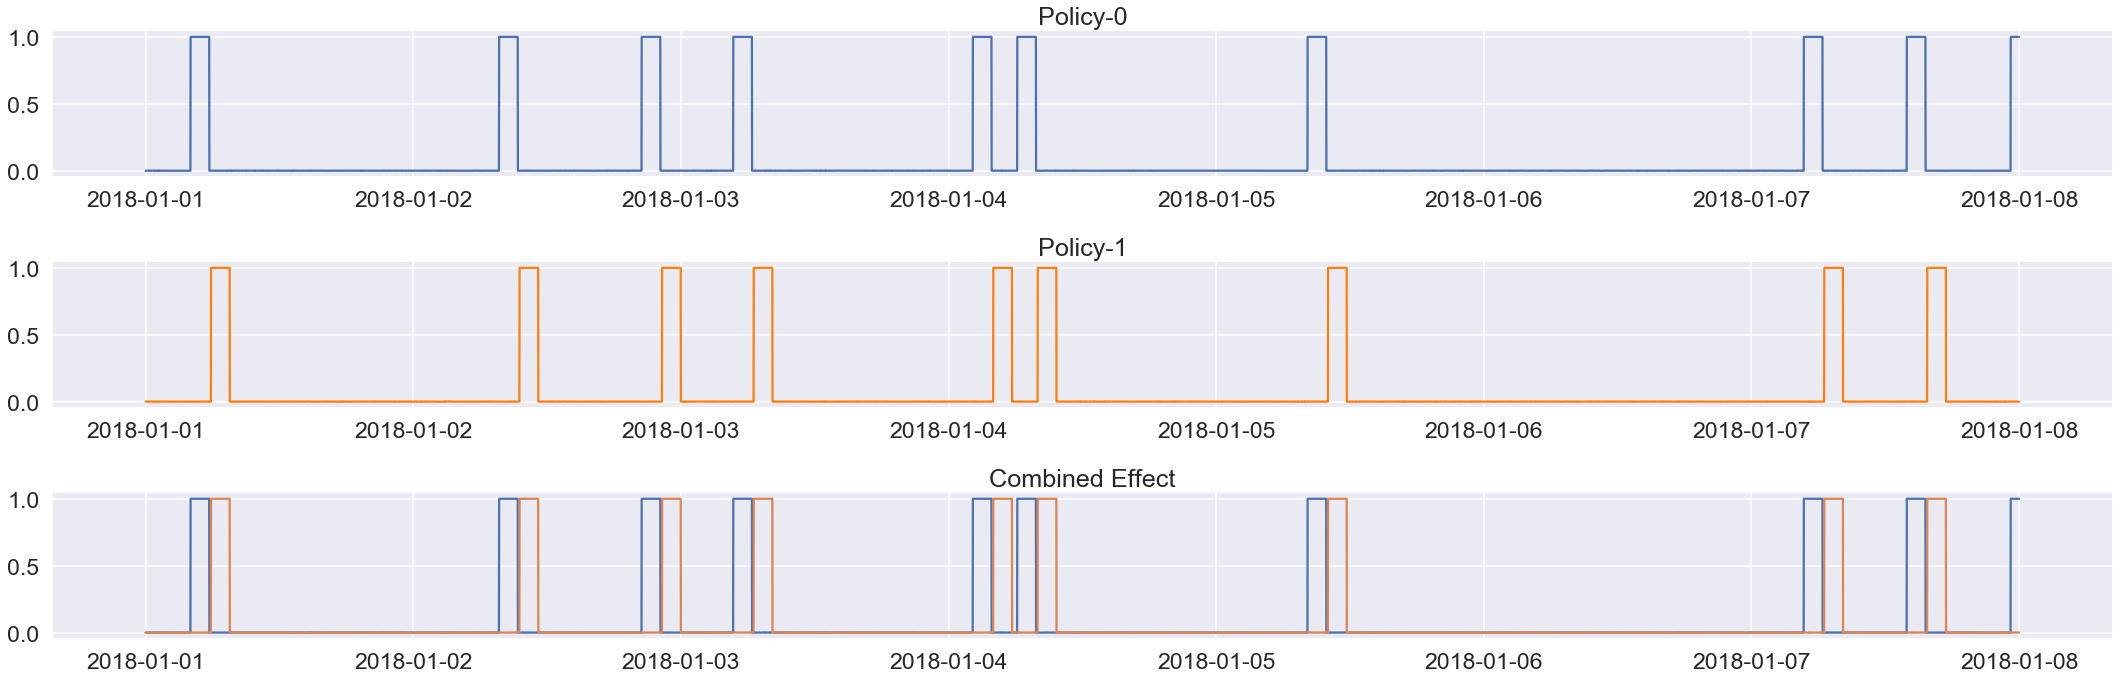

In [9]:
#df.plot(title="Policy Violations wrt time")

fig, axs = plt.subplots(3)
#fig.suptitle('Policy Violations wrt time')
axs[0].plot(df['policy-0'])
axs[0].set_title("Policy-0")
axs[1].plot(df['policy-1'],'tab:orange')
axs[1].set_title("Policy-1")
axs[2].plot(df)
axs[2].set_title("Combined Effect")
#tight layout improves spacing between figures and reduces overlap
fig.tight_layout()

## Causality Detection using Granger

### Check stationarity of data

In [10]:
from statsmodels.tsa.stattools import adfuller, kpss

## ADF Null hypothesis: there is a unit root, meaning series is non-stationary
## So, if the P-Value is less than the significance level (0.05), we reject the null hypothesis.
def augmented_dickey_fuller_statistics(time_series):
    #do we need the autolag param?
    result = adfuller(time_series.values, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Result-2: %f' % result[2])
    print('Result-3: %f' % result[3])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print(f'------------- Result: The series is {"not " if result[1] > 0.05 else ""}stationary -------------')
    if result[1] > 0.05 :
        return False
    else : 
        return True


## KPSS Null hypothesis: there is a no unit root, meaning series is stationary
## So, if the P-Value is less than the significance level (0.05), we reject the null hypothesis.
def kpss_test(series, **kw):    
    #statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    statistic, p_value, n_lags, critical_values = kpss(series,regression='c')
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'------------- Result: The series is {"not " if p_value < 0.05 else ""}stationary -------------')
    if p_value < 0.05 :
        return False
    else : 
        return True




In [11]:
verdict_1 = augmented_dickey_fuller_statistics(df['policy-0'])
print("Is the series ADF Stationary: ", verdict_1)

verdict_2 = augmented_dickey_fuller_statistics(df['policy-1'])
print("Is the series ADF Stationary: ", verdict_2)

verdict_3 = kpss_test(df['policy-0'])
print("Is the series KPSS Stationary: ", verdict_3)

verdict_4 = kpss_test(df['policy-1'])
print("Is the series KPSS Stationary: ", verdict_4)



ADF Statistic: -7.145306
p-value: 0.000000
Result-2: 0.000000
Result-3: 10080.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
------------- Result: The series is stationary -------------
Is the series ADF Stationary:  True
ADF Statistic: -7.425637
p-value: 0.000000
Result-2: 0.000000
Result-3: 10080.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
------------- Result: The series is stationary -------------
Is the series ADF Stationary:  True
KPSS Statistic: 0.132663011466883
p-value: 0.1
num lags: 39
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
------------- Result: The series is stationary -------------
Is the series KPSS Stationary:  True
KPSS Statistic: 0.14188062522364595
p-value: 0.1
num lags: 39
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
------------- Result: The series is stationary -------------
Is the series KPSS Stationary:  True


### Check causality
#### Background:
It is based on the idea that if X causes Y, then the forecast of Y based on previous values of Y AND the previous values of X should outperform the forecast of Y based on previous values of Y alone.
#### Code:
The values are in the first column and the predictor (X) is in the second column.
The Null hypothesis is: the series in the second column, does not Granger cause the series in the first. 
If the P-Values are less than a significance level (0.05) then you reject the null hypothesis and conclude that the said lag of X is indeed useful.
The second argument maxlag says till how many lags of Y should be included in the test.




In [13]:
from statsmodels.tsa.stattools import grangercausalitytests


def run_granger_test(dframe, _maxlag):
    result = grangercausalitytests(dframe, maxlag=_maxlag, verbose=False)

    p_values_ftest = [round(result[i+1][0]['ssr_ftest'][1],4) for i in range(_maxlag)]
    p_values_chi2test = [round(result[i+1][0]['ssr_chi2test'][1],4) for i in range(_maxlag)]
    p_values_lrtest = [round(result[i+1][0]['lrtest'][1],4) for i in range(_maxlag)]
    p_values_pftest = [round(result[i+1][0]['params_ftest'][1],4) for i in range(_maxlag)]

    print("\n")
    print("p values for ftest: ", p_values_ftest)
    print("p values for chi2test: ", p_values_chi2test)
    print("p values for lrtest: ", p_values_lrtest)
    print("p values for pftest: ",p_values_pftest)  

    #only taking results of chisquare tests
    min_p = np.min(p_values_chi2test)
    #print(min_p)
    lag=p_values_ftest.index(min_p)
    if min_p < 0.05 :
        print("\nPolicy-0 indeed Granger causes Policy-1. p_value detected to be: ", min_p, " at lag ",lag+1)
    else : 
        print("\nNo Granger Causality detected ")

#if records are obtained every minute, perhaps lag of 10~15 min is reasonable
if verdict_1 and verdict_2 :
    run_granger_test(df[['policy-1', 'policy-0']],15)
else :
    print("\nMake the data stationary first BEFORE applying Granger")



p values for ftest:  [0.4471, 0.7456, 0.897, 0.9623, 0.9873, 0.996, 0.9988, 0.9996, 0.9999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
p values for chi2test:  [0.447, 0.7455, 0.8969, 0.9623, 0.9873, 0.9959, 0.9988, 0.9996, 0.9999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
p values for lrtest:  [0.447, 0.7455, 0.8969, 0.9623, 0.9873, 0.9959, 0.9988, 0.9996, 0.9999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
p values for pftest:  [0.4471, 0.7456, 0.897, 0.9623, 0.9873, 0.996, 0.9988, 0.9996, 0.9999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Policy-0 indeed Granger causes Policy-1. p_value detected to be:  0.0  at lag  10
